Notebook to investigate how the IRFs change with different parameter values

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import sys
import numpy as np
import pandas as pd
from copy import deepcopy

from HANKStickyModel import HANKStickyModelClass
from HANKStickyAnalytics import HANKStickyAnalyticsClass

# Settings

In [2]:
# settings

# save
save_models = False

# paths
path_savefolder = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + 'saved_models')  # save folder for models
path_images = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + 'images' + os.sep + 'parameter_sensitivity') # save folder for images

# model settings
baseline_inattention = 0.935 # baseline setting for inattention

shock_baseline = {'jump_eg': 0.0001,
                  'rho_eg': 0.7,
                  'jump_em': 0.0}

updated_par_base = {**{'inattention': baseline_inattention}, **shock_baseline} # update parameters used for all models


# init
models = {}
models_solved = {}
model_labels = {}
outputs = {}

In [3]:
# paths to plot
# paths = ['G', 'Y', 'C_hh', 'L_hh', 'A_hh', 'K', 'I', 'Z',
#          'N', 'w', 'tau', 'Pi', 'i', 'r',
#          'qB', 'p_eq', 'Div']
paths = ['G', 'Y', 'C_hh', 'I',
         'N', 'w', 'tau', 'Pi', 'r',
         'qB']
paths_short = ['Y', 'C_hh', 'K', 'I', 'N', 'w']
lvl_value = ['eg', 'em', 'ez', 'i', 'Pi', 'Pi_w']
abs_diff = ['r', 'ra', 'rl', 'i']
facs = {'r':100,'ra':100,'rl':100, 'i':100}

# Functions

In [4]:
def solve_model_list(models, compare_models, models_solved={}, use_baseline=None, do_non_linear=False):
    """ solve models and store in list

        :param models: dictionary of models with model parameter settings
        :param compare_models: list of model names from models dictionary to compare
        :param models_solved dictionary with solved models
        :param use_baseline: name of baseline model to use"""

    # init container for models
    for m in compare_models:
        # init model
        print('\r' + f' -------- Model: {m} ---------')

        updated_par_temp = {**updated_par_base, **models[m]}

        model = HANKStickyModelClass(name=m, par=updated_par_temp, savefolder=path_savefolder)

        if use_baseline != None:
            if use_baseline in models_solved:
                m_baseline = models_solved[use_baseline]
                model = HANKStickyAnalyticsClass.solution_routine(model, baseline_model=m_baseline, update_par=updated_par_temp, do_non_linear=do_non_linear)
            else:
                assert use_baseline == compare_models[
                    0], 'Baseline model has to be the first model that is solved if not already is models_solved dictionary'
                model = HANKStickyAnalyticsClass.solution_routine(model, baseline_model=None, do_non_linear=do_non_linear)
        else:
            model = HANKStickyAnalyticsClass.solution_routine(model, baseline_model=None, do_non_linear=do_non_linear)

        models_solved[m] = model

    return models_solved

In [4]:
# def solution_routine(model, baseline_model=None, update_par={}, do_non_linear=False, save_model=False):
#     """ solve model
#
#         :param model: initialied model.
#         :param baseline_model: use steady state from this baseline model and only compute jacs and IRFs.
#         :param update_par: specify parameters to update from baseline model.
#         :param do_non_linear: find non-linear transition path if TRUE.
#         :param save_model: save model with date timestamp if TRUE."""
#
#     if baseline_model == None:
#         print("\r"+'Find steady state  ',end="")
#         model.find_ss(do_print=False)
#     else:
#         print("\r"+f'Use steady state from {baseline_model.name}')
#         model = baseline_model.copy()
#         for p in update_par.keys():
#             model.par.__dict__[p] = update_par[p]
#
#     print("\r"+'Compute Jacobians  ',end="")
#     model.compute_jacs(do_print=False)
#     if do_non_linear:
#         print("\r"+'Find transition path',end="")
#         model.find_transition_path(do_print=False, do_print_unknowns=False)
#     print("\r"+'Find IRFs           ',end="")
#     model.find_IRFs(do_print=False)
#
#     if save_model:
#         m_name = model + f'_{datetime.datetime.now().strftime("%m_%d")}'
#         model.name = m_name
#         model.save()
#         print("\r"+f'saved {m_name}')
#
#     return model
#
# def solve_model_list(models, compare_models, models_solved={}, use_baseline=None, do_non_linear=False):
#     """ solve models and store in list
#
#         :param models: dictionary of models with model parameter settings
#         :param compare_models: list of model names from models dictionary to compare
#         :param models_solved dictionary with solved models
#         :param use_baseline: name of baseline model to use"""
#
#
#     # init container for models
#     for m in compare_models:
#         # init model
#         print('\r'+f' -------- Model: {m} ---------')
#
#         updated_par_temp = {**updated_par_base, **models[m]}
#
#         model = HANKStickyModelClass(name=m, par=updated_par_temp, savefolder=path_savefolder)
#
#         if use_baseline != None:
#             if use_baseline in models_solved:
#                 m_baseline = models_solved[use_baseline]
#                 model = solution_routine(model, baseline_model=m_baseline, update_par=updated_par_temp, do_non_linear=do_non_linear)
#             else:
#                 assert use_baseline == compare_models[0], 'Baseline model has to be the first model that is solved if not already is models_solved dictionary'
#                 model = solution_routine(model, baseline_model=None, do_non_linear=do_non_linear)
#         else:
#             model = solution_routine(model, baseline_model=None, do_non_linear=do_non_linear)
#
#         models_solved[m] = model
#
#     return models_solved
#
#
# def get_sticky_IRFs(model, inattention = 0.935):
#     """ get sticky information IRFs for list of models"""
#
#     m_sticky = f"{m}_sticky"
#
#     print('\r'+f' -------- Model: {m_sticky} ---------')
#
#     model_sticky = model.copy()
#
#     model_sticky.name = m_sticky
#
#     model_sticky.par.inattention = inattention
#
#     print("\r"+'Compute Jacobians',end="")
#     model_sticky.compute_jacs(do_print=False)
#     print("\r"+'Find IRFs',end="")
#     model_sticky.find_IRFs(do_print=False)
#
#     print("\r"+'                  ',end="")
#
#     return model_sticky

In [5]:
def get_no_IRF_output(model, result={}):
    """Savor MPCs and fiscal multipliers in dictionary"""

    m = model.name

    result_emtpy = {
        'MPC': {},
        'Fiscal Multiplier': {
            'impact': np.nan,
            'cumulative': np.nan
        },
        'JAC_diff':{
            'abs': np.nan,
            'perc': np.nan
        }
    }
    income_types_MPC = ['labor', 'liquid', 'illiquid']
    for i in income_types_MPC:
        result_emtpy['MPC'][i] = {
                'annual': np.nan,
                'quarterly': np.nan
                }

    result[m] = result_emtpy
    for i in income_types_MPC:
        for i_q, q_i in enumerate(['quarterly', 'annual']):
            result[m]['MPC'][i][q_i] = round(model.calc_MPC(annual=i_q, income=i), 3)
    fmp_impact, fmp_cum = model.calc_FMP()
    result[m]['Fiscal Multiplier']['impact'] = round(fmp_impact, 3)
    result[m]['Fiscal Multiplier']['cumulative'] = round(fmp_cum, 3)


Things to include:
1. Different spending types
2. Different shock trajectories
3. Different rigidity parameters
   - Fiscal multiplier based on output being demand determined. Partial equilibrium logic from Hagedorn: "... ensures that the increase in government spending stimulates aggregate demand in the first place. The typical underlying assumption is that prices are rigid so that firms adjust quantities and not only prices in response to increased government demand. Firms increase production to satisfy this demand by raising employment, capital and wages, which leads to higher household income."
   - Analysis about the multiplier " This requires a model that, first, features the right amount of nominal rigidities, so that the aggregate demand channel is as in the data"

4. Different MP reactions
5. Different inattention levels
6. MPC's
    - "Important to also look at how MPCs change, because: " significant deviation from the permanent income hypothesis, such that households have a high marginal propensity to consume (MPC) out of the transitory increase in income induced by the stimulus, generating a nontrivial indirect effect.  Higher private consumption directly induced by government spending then leads to further increase in labor demand, income, consumption and so on."
     - Analysis about fiscal multiplier  "requires incorporating observed marginal propensities to consume that imply a substantial deviation from the permanent income hypothesis"
7. FP shock persistence (big focus in "The intertemporal keynesian cross" paper.


# Spending types
Compare responses of

1. a purely tax financed shock
2. a purely deficit financed shock
3. a shock that is financed by increased taxes and deficit

In [6]:
models['tax_financing'] = {
    'phi_G': 1.0,
    'inattention': 0.0
}

models['mixed_financing'] = {
    'phi_G': 0.5,
    'inattention': 0.0
}

models['deficit_financing'] = {
    'phi_G': 0.0,
    'inattention': 0.0
}

In [7]:
compare_models = ['tax_financing', 'deficit_financing', 'mixed_financing']
models_solved = solve_model_list(models, compare_models, models_solved, do_non_linear=False, use_baseline='tax_financing')
for m in compare_models:
    m_sticky = f"{m}_sticky"
    models_solved[m_sticky] = HANKStickyAnalyticsClass.get_sticky_IRFs(models_solved[m], inattention=baseline_inattention)

 -------- Model: tax_financing ---------
 -------- Model: deficit_financing ---------
Use steady state from tax_financing
 -------- Model: mixed_financing ---------
Use steady state from tax_financing
 -------- Model: tax_financing_sticky ---------
 -------- Model: deficit_financing_sticky ---------
 -------- Model: mixed_financing_sticky ---------
                  

In [8]:
for m in compare_models:
    get_no_IRF_output(models_solved[m], result=outputs)

KeyError: ('C_hh', 'Z')

#### Plot

In [ ]:
compare_models = ['tax_financing_sticky', 'deficit_financing_sticky', 'mixed_financing_sticky']
labels = [f'$\phi_G = 0, \\theta = {baseline_inattention}$', f'$\phi_G = 1, \\theta = {baseline_inattention}$', f'$\phi_G = 0.5, \\theta = {baseline_inattention}$']
models_list = [models_solved[m] for m in compare_models]
models_solved['tax_financing'].compare_IRFs(models_list, labels, paths, lvl_value=lvl_value, do_shocks=True, do_targets=False, ncols=3, do_linear=True, do_non_linear=False)

#### Other output

In [ ]:
compare_models = ['tax_financing_sticky', 'deficit_financing_sticky', 'mixed_financing_sticky']
for m in compare_models:
    get_no_IRF_output(models_solved[m], result=outputs, models_solved=models_solved)
pd.DataFrame.from_dict(outputs).T

In [11]:
# reset dictionaries to save memory
models = {}
models_solved = {}
model_labels = {}

## Tax rate responsivness

For a deficit financed shock, the speed of adjustment of the tax rate can differ.
If the tax rate does not adjust, there is no convergence to the old steady state with the previous debt ratio.

In [6]:
models['deficit_financing_phi_tau_005'] = {
    'phi_G': 0.0,
    'phi_tau': 0.05,
    'inattention': 0.0
}
models['deficit_financing_phi_tau_01'] = {
    'phi_G': 0.0,
    'phi_tau': 0.1,
    'inattention': 0.0
}
models['deficit_financing_phi_tau_0025'] = {
    'phi_G': 0.0,
    'phi_tau': 0.025,
    'inattention': 0.0
}

In [8]:
compare_models_no_sticky = ['deficit_financing_phi_tau_01', 'deficit_financing_phi_tau_005', 'deficit_financing_phi_tau_0025']
models_solved = solve_model_list(models, compare_models_no_sticky, models_solved, do_non_linear=False, use_baseline='deficit_financing_phi_tau_01')
for m in compare_models_no_sticky:
    m_sticky = f"{m}_sticky"
    models_solved[m_sticky] = HANKStickyAnalyticsClass.get_sticky_IRFs(models_solved[m], inattention=baseline_inattention)

 -------- Model: deficit_financing_phi_tau_01 ---------
Use steady state from deficit_financing_phi_tau_01
 -------- Model: deficit_financing_phi_tau_005 ---------
Use steady state from deficit_financing_phi_tau_01_copy
 -------- Model: deficit_financing_phi_tau_001 ---------
Use steady state from deficit_financing_phi_tau_01_copy
 -------- Model: Modelclass: HANKStickyModelClass
Name: deficit_financing_phi_tau_01_copy

namespaces: ['par', 'ini', 'sim', 'ss', 'path']
other_attrs: ['par', 'ini', 'ss', 'path', 'sim', 'grids_hh', 'pols_hh', 'inputs_hh', 'inputs_hh_z', 'outputs_hh', 'intertemps_hh', 'shocks', 'unknowns', 'targets', 'varlist', 'jac', 'H_U', 'H_Z', 'jac_hh', 'IRF']
savefolder: C:\Users\Yannik\Meine Ablage\Uni\Master\Master Thesis\Thesis_Code\Hump_Jump_Replication\saved_models
cpp_filename: None

par:
 Nfix = 1 [int]
 Nz = 7 [int]
 r_ss_target = 0.012272234429039353 [float]
 K_Y_ratio = 8.92 [float]
 L_Y_ratio = 0.92 [float]
 hh_wealth_Y_ratio = 15.28 [float]
 G_Y_ratio = 0.1

In [10]:
models_solved.keys()

dict_keys(['deficit_financing_phi_tau_01', 'deficit_financing_phi_tau_005', 'deficit_financing_phi_tau_001', 'deficit_financing_phi_tau_01_sticky', 'deficit_financing_phi_tau_005_sticky', 'deficit_financing_phi_tau_001_sticky'])

### shocks ###


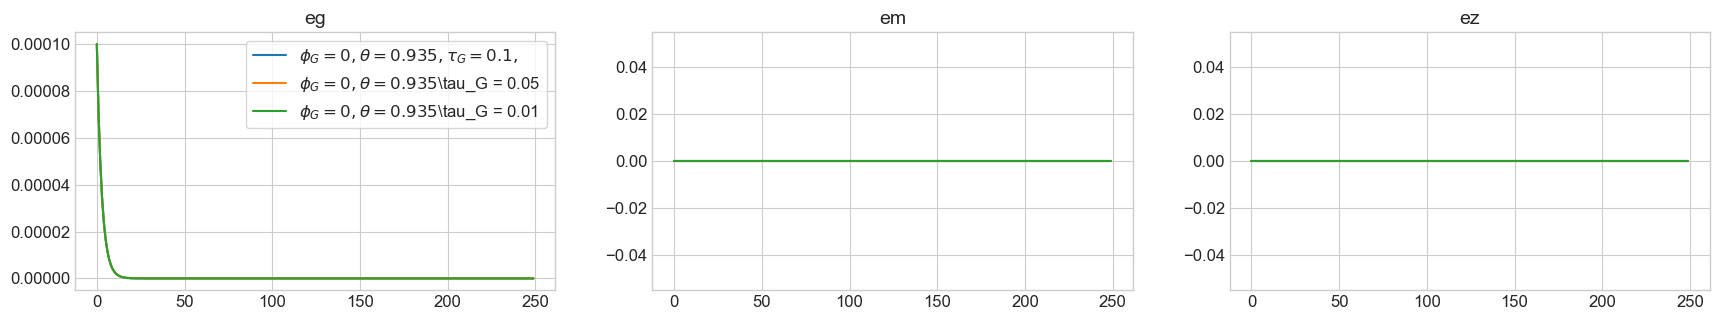


### varnames ###


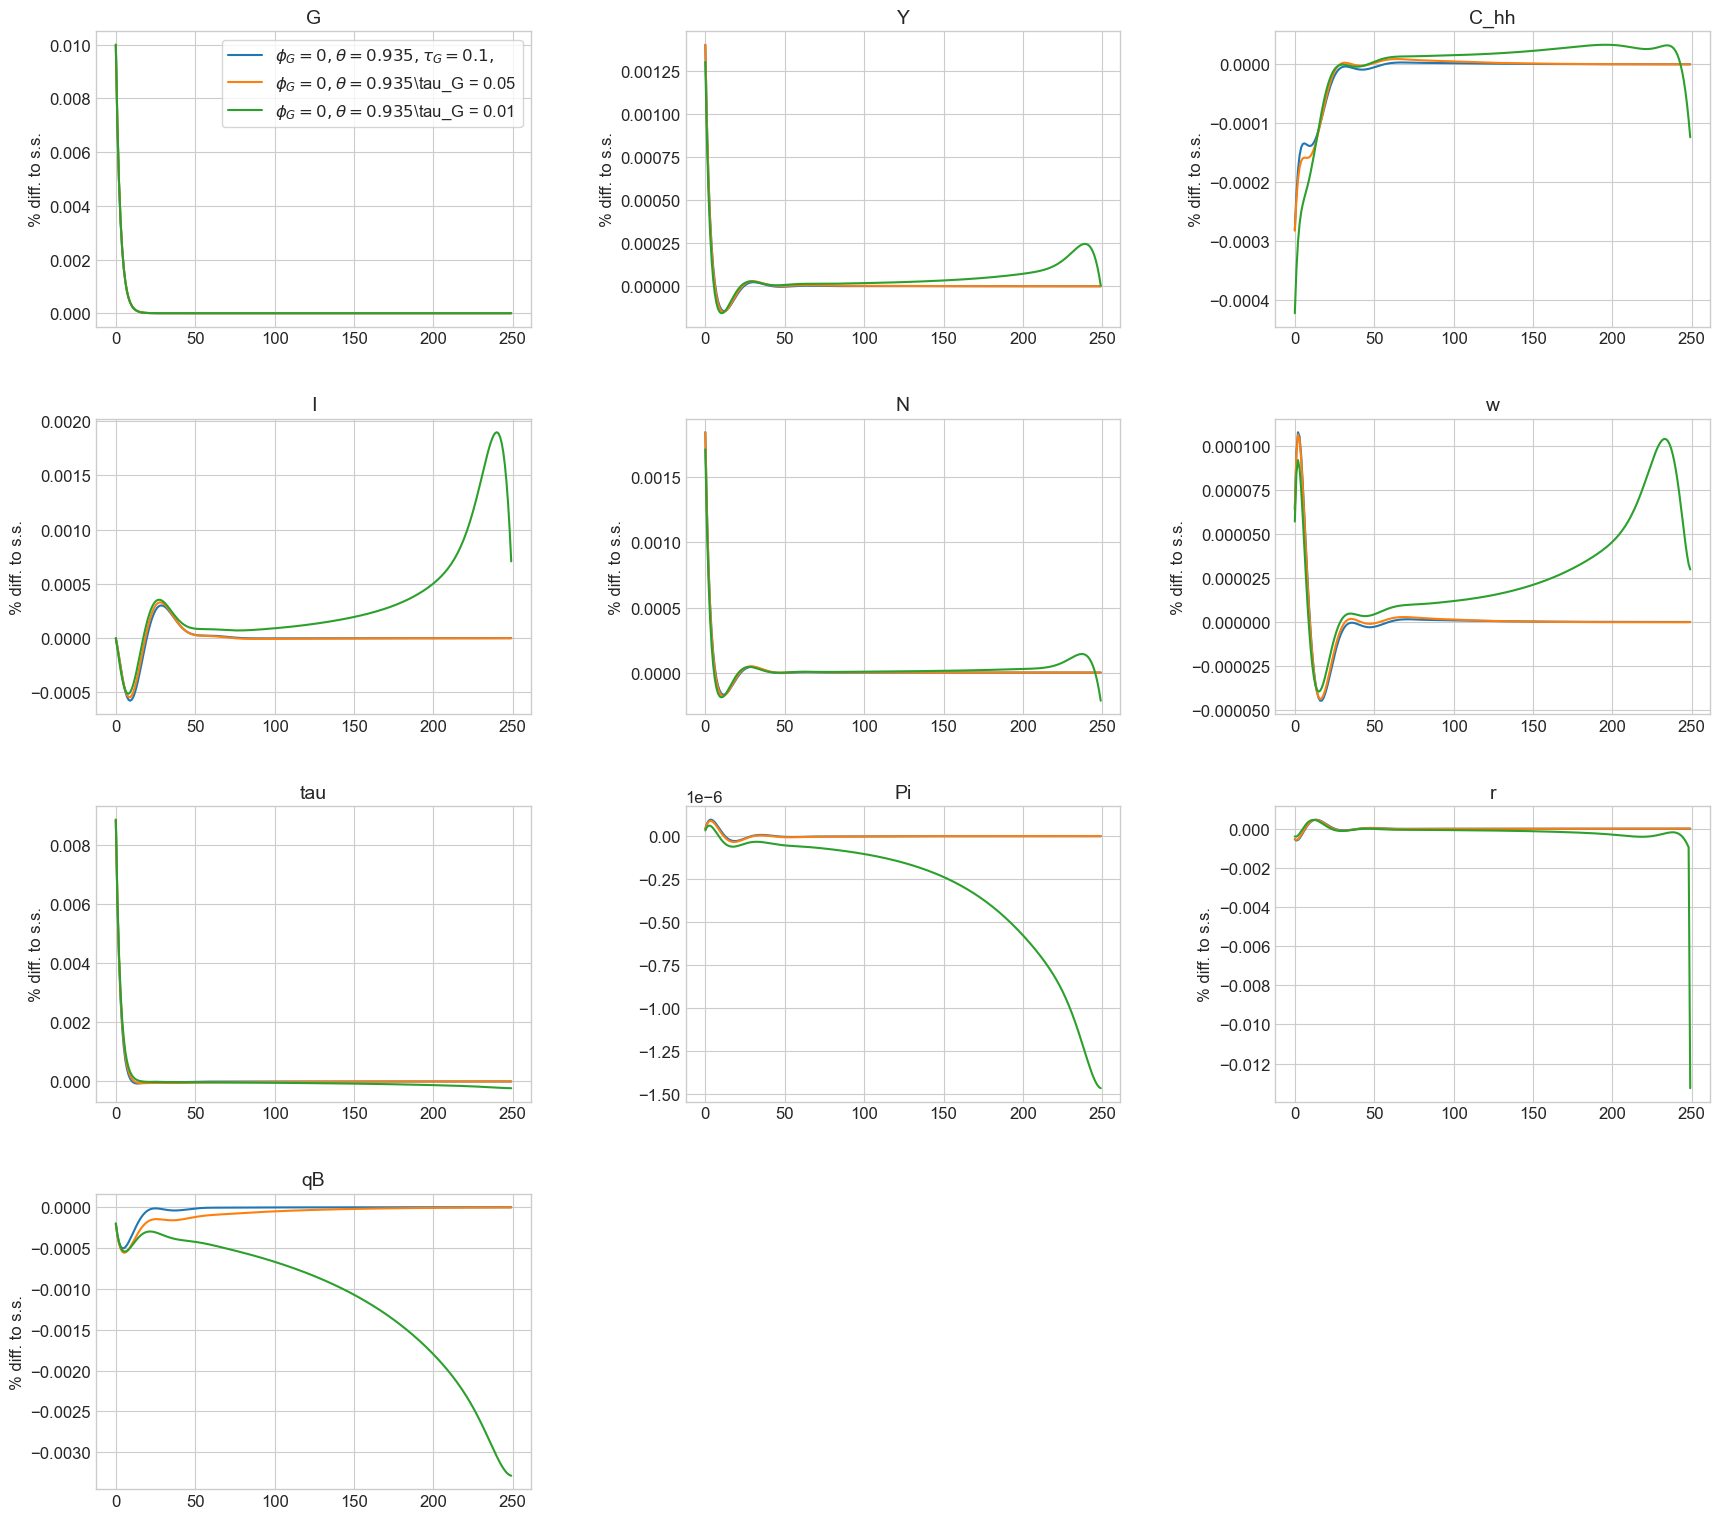

In [9]:
compare_models = ['deficit_financing_phi_tau_01_sticky', 'deficit_financing_phi_tau_005_sticky', 'deficit_financing_phi_tau_0025']
labels = [f'$\phi_G = 0, \\theta = {baseline_inattention}, \\tau_G = 0.1,$', f'$\phi_G = 0, \\theta = {baseline_inattention}$\\tau_G = 0.05', f'$\phi_G = 0, \\theta = {baseline_inattention}$\\tau_G = 0.025']
models_list = [models_solved[m] for m in compare_models]
models_solved['deficit_financing_phi_tau_01_sticky'].compare_IRFs(models_list, labels, paths, lvl_value=lvl_value, do_shocks=True, do_targets=False, ncols=3, do_linear=True, do_non_linear=False)

In [ ]:
for m in compare_models_no_sticky+compare_models:
    get_no_IRF_output(models_solved[m], result=outputs, models_solved=models_solved)
pd.DataFrame.from_dict(outputs).T

In [20]:
# reset dictionaries to save memory
models = {}
models_solved = {}
model_labels = {}

# Inattention levels

In [27]:
models['mixed_f_theta_0935'] = {
    'phi_G': 0.5,
    'inattention': 0.935
}
models['mixed_f_theta_085'] = {
    'phi_G': 0.5,
    'inattention': 0.85
}
models['mixed_f_theta_07'] = {
    'phi_G': 0.5,
    'inattention': 0.7
}
models['mixed_f_theta_1'] = {
    'phi_G': 0.5,
    'inattention': 1.0
}
models['mixed_f_theta_0975'] = {
    'phi_G': 0.5,
    'inattention': 0.975
}
models['mixed_f_theta_0'] = {
    'phi_G': 0.5,
    'inattention': 0.0
}

In [28]:
compare_models = ['mixed_f_theta_0']
models_solved = solve_model_list(models, compare_models, models_solved)
for m in ['mixed_f_theta_07', 'mixed_f_theta_085', 'mixed_f_theta_0935', 'mixed_f_theta_1', 'mixed_f_theta_0975']:
    models_solved[m] = HANKStickyAnalyticsClass.get_sticky_IRFs(models_solved['mixed_f_theta_0'], inattention=models[m]['inattention'])

 -------- Model: mixed_f_theta_0 ---------
 -------- Model: mixed_f_theta_07_sticky ---------
 -------- Model: mixed_f_theta_085_sticky ---------
 -------- Model: mixed_f_theta_0935_sticky ---------
 -------- Model: mixed_f_theta_1_sticky ---------
                  th

### shocks ###


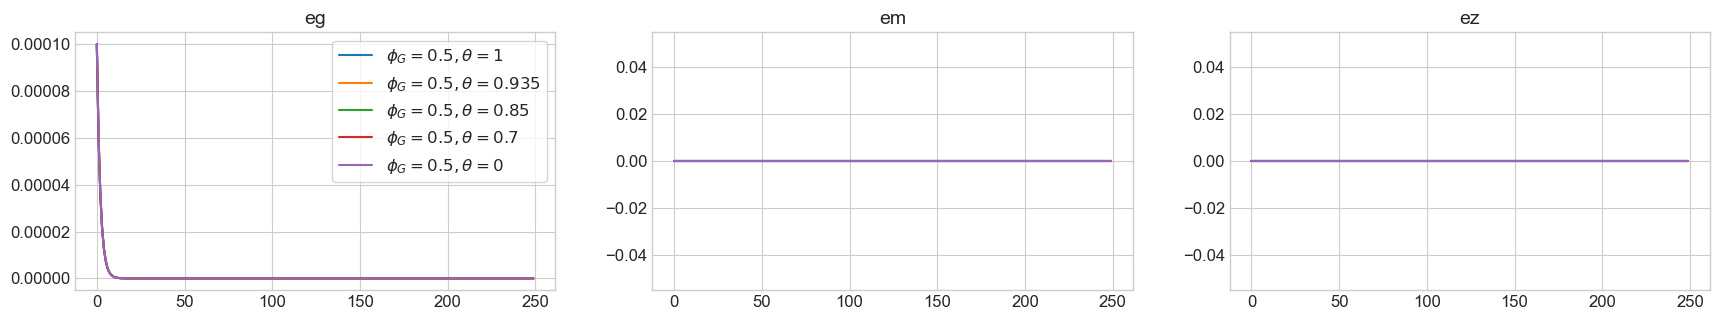


### varnames ###


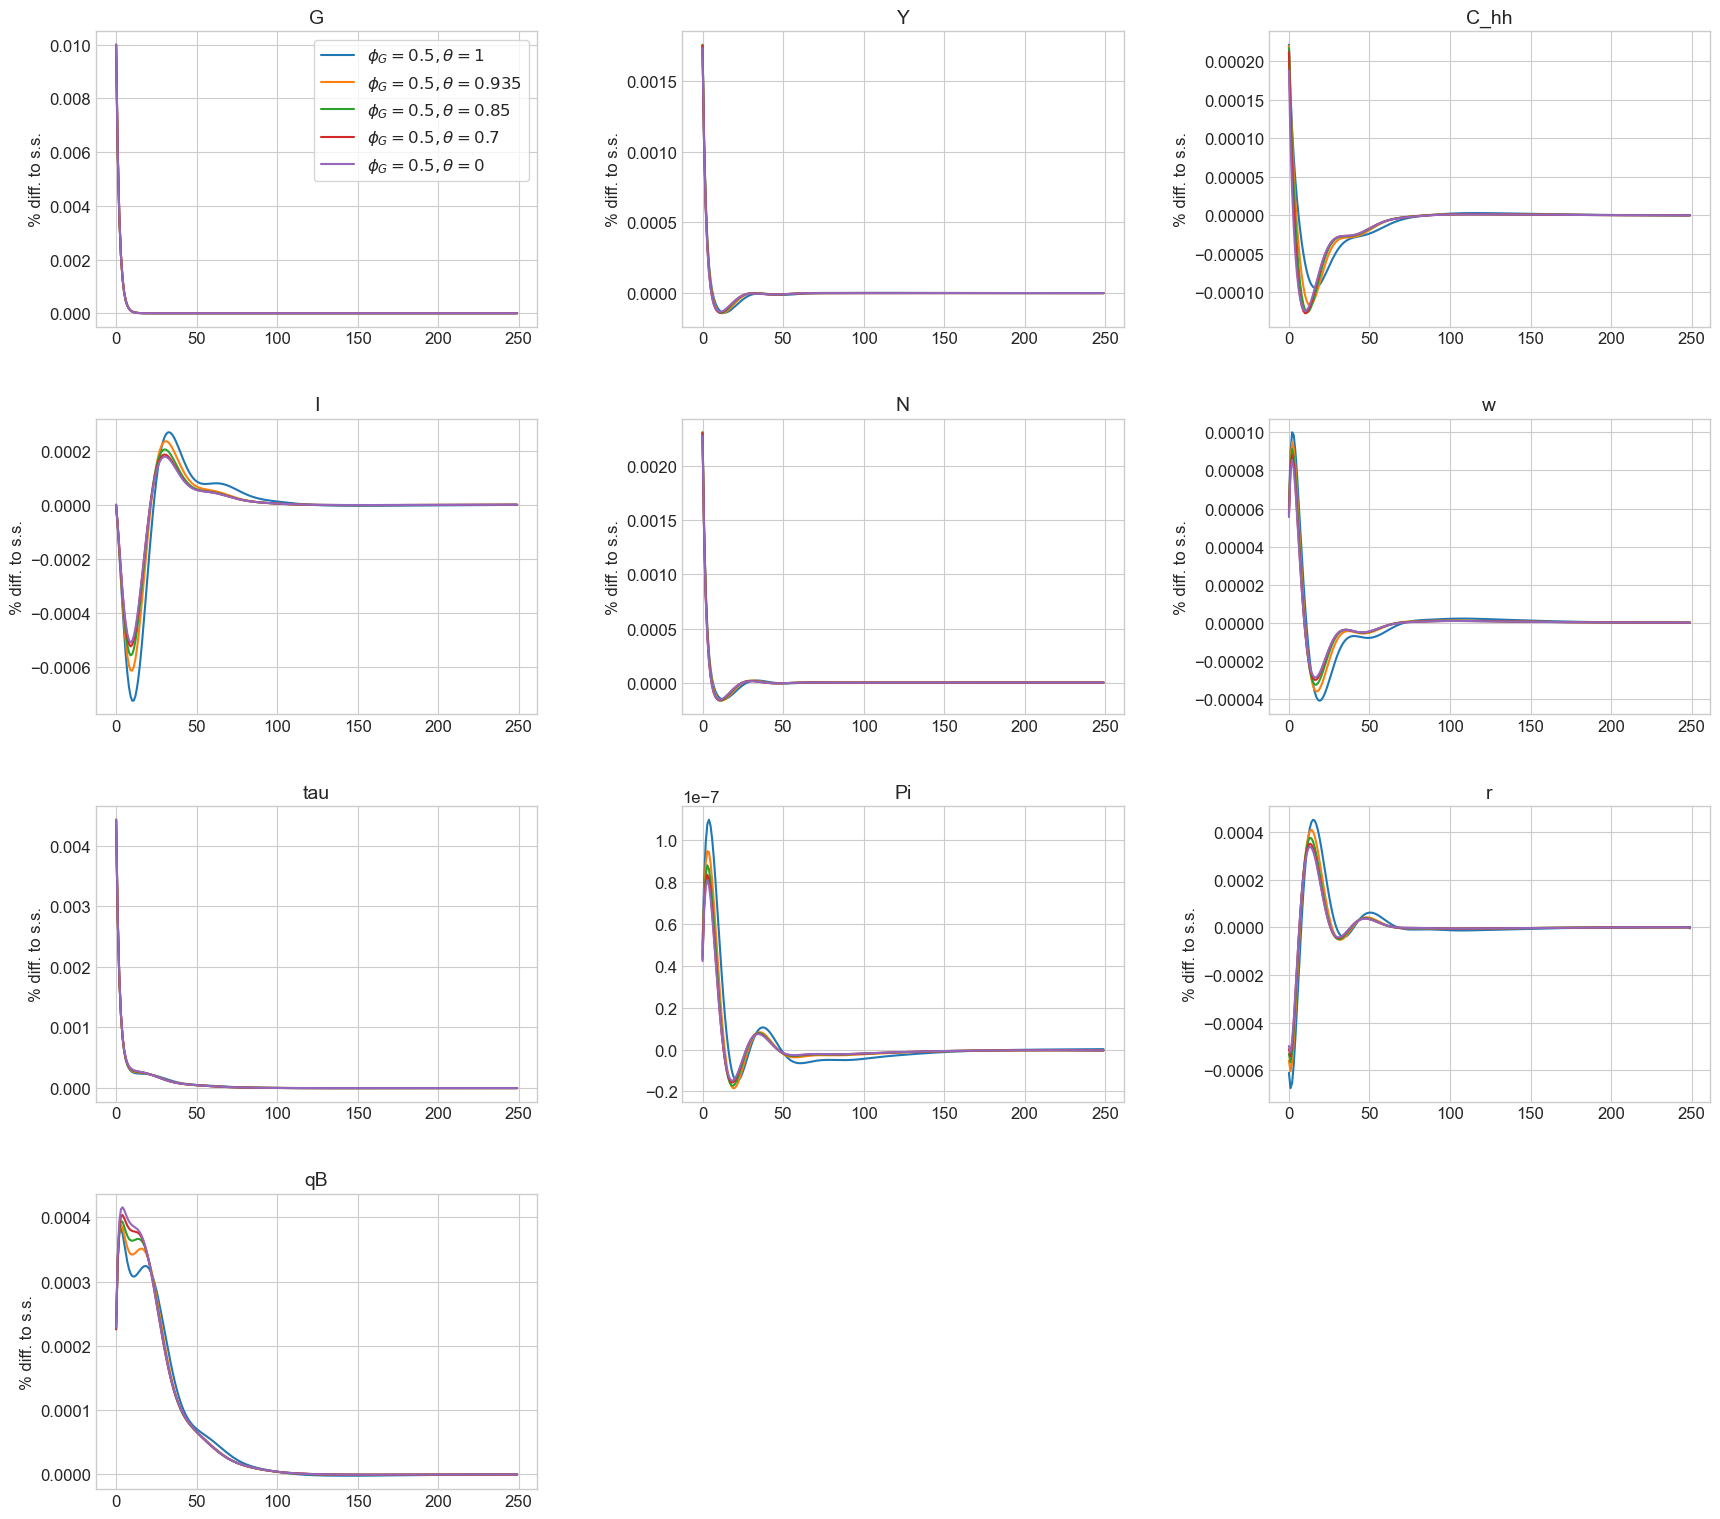

In [29]:
compare_models = ['mixed_f_theta_1', 'mixed_f_theta_0935', 'mixed_f_theta_085', 'mixed_f_theta_07', 'mixed_f_theta_0', 'mixed_f_theta_0975']
labels = [f'$\phi_G = 0.5, \\theta = {1}$', f'$\phi_G = 0.5, \\theta = {0.935}$', f'$\phi_G = 0.5, \\theta = {0.85}$', f'$\phi_G = 0.5, \\theta = {0.7}$', f'$\phi_G = 0.5, \\theta = {0}$', f'$\phi_G = 0.5, \\theta = {0.975}$']
models_list = [models_solved[m] for m in compare_models]
models_solved['mixed_f_theta_0'].compare_IRFs(models_list, labels, paths, lvl_value=lvl_value, do_shocks=True, do_targets=False, ncols=3, do_linear=True, do_non_linear=False)

In [30]:
for m in compare_models:
    get_no_IRF_output(models_solved[m], result=outputs, models_solved=models_solved)
pd.DataFrame.from_dict(outputs).T

,MPC,Fiscal Multiplier,JAC_diff
tax_financing,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 1.315, 'cumulative': 0.603}","{'abs': nan, 'perc': nan}"
deficit_financing,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 0.851, 'cumulative': 0.56}","{'abs': nan, 'perc': nan}"
mixed_financing,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 1.083, 'cumulative': 0.582}","{'abs': nan, 'perc': nan}"
tax_financing_sticky,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 1.319, 'cumulative': 0.643}","{'abs': nan, 'perc': nan}"
deficit_financing_sticky,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 0.876, 'cumulative': 0.583}","{'abs': nan, 'perc': nan}"
mixed_financing_sticky,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 1.097, 'cumulative': 0.613}","{'abs': nan, 'perc': nan}"
deficit_financing_phi_tau_01,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 0.851, 'cumulative': 0.56}","{'abs': nan, 'perc': nan}"
deficit_financing_phi_tau_005,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 0.846, 'cumulative': 0.57}","{'abs': nan, 'perc': nan}"
deficit_financing_phi_tau_02,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 0.856, 'cumulative': 0.558}","{'abs': nan, 'perc': nan}"
deficit_financing_phi_tau_01_sticky,"{'labor': {'annual': 0.432, 'quarterly': 0.336...","{'impact': 0.876, 'cumulative': 0.583}","{'abs': nan, 'perc': nan}"


In [ ]:
# reset dictionaries to save memory
models = {}
models_solved = {}
model_labels = {}